# Load libraries

In [1]:
import numpy as np
import pandas as pd
import Bio.SeqIO as bio
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
import math

# Load data

Here we load data as a matrix

In [2]:
seq = []
for i, record in enumerate(bio.parse("data/PF00440_rp15.txt", "fasta")):
    seq.append(list(str(record.seq).upper()))

# Data preparation

Then we replace '-' by np.Nan (in fact it will be 'nan')

In [3]:
df = np.array(seq).astype('<U3')
df[df == '-'] = np.NaN
df

array([['I', 'L', 'A', ..., 'E', 'A', 'L'],
       ['I', 'L', 'Q', ..., 'E', 'A', 'L'],
       ['L', 'I', 'T', ..., 'F', 'A', 'A'],
       ...,
       ['nan', 'nan', 'nan', ..., 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'A', ..., 'N', 'H', 'nan'],
       ['nan', 'L', 'Q', ..., 'R', 'nan', 'nan']], dtype='<U3')

Here we drop columns where more than 30% empty values

In [4]:
empty_col = [] # create list for columns with a lot of nan
for column in range(df.shape[1]): # iter over all columns
  perc_nan = sum(df[:,column] == 'nan') / len(df) * 100 # calculate percentage of nan
  if perc_nan > 30:
    empty_col.append(column) # if nan > 30 then add this columns to the list
    
# Delete columns
df = np.delete(df,empty_col,1) # delete all columns from the list

Here we can see distribution of empty values in columns

X - % of empty values in column

Y - number of columns with such % of empty values

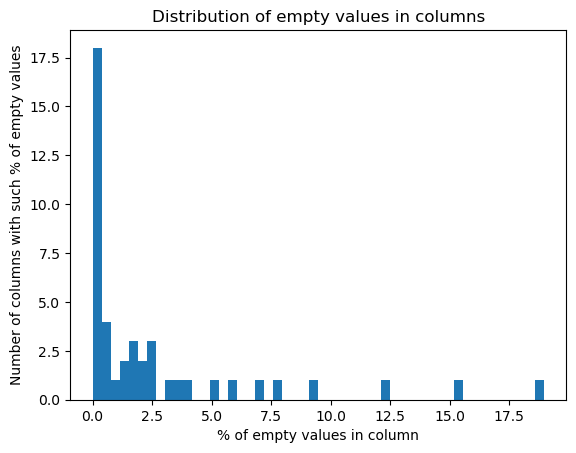

In [6]:
plt.hist(pd.DataFrame(df).replace('nan',np.NaN).isna().sum()/len(df)*100,bins = 50);

plt.title('Distribution of empty values in columns');
plt.xlabel('% of empty values in column');
plt.ylabel('Number of columns with such % of empty values');

Final shape of our data matrix

In [7]:
df.shape

(12702, 44)

## Make labels

Make label encoding

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

Collect all existing labels

In [8]:
labels = []
for col in range(df.shape[1]):
  labels = set(list(np.unique(df[:,col])) + list(labels)) # collect all unique labels from all columns

Remove nan label

In [9]:
labels = list(labels) # make a list
labels.remove('nan') # remove nan

In [10]:
# fit and apply the model for transformation 
le.fit(np.array(labels)) 
labels_transform = le.transform(np.array(labels))

In [11]:
le.inverse_transform(labels_transform) # check how inverse operation works

array(['S', 'T', 'Q', 'A', 'M', 'W', 'K', 'V', 'I', 'L', 'R', 'D', 'X',
       'H', 'G', 'F', 'C', 'E', 'P', 'Y', 'N'], dtype='<U1')

In [12]:
labels_transform # our labels

array([15, 16, 13,  0, 10, 18,  8, 17,  7,  9, 14,  2, 19,  6,  5,  4,  1,
        3, 12, 20, 11])

Let's apply the model to the data

In [13]:
df_labeled = df.copy() # copy initial dataset

for i,label in enumerate(le.classes_):
  df_labeled[df_labeled == label] = labels_transform[i] # apply transformation

Our final matrix

In [14]:
df_labeled

array([['9', '15', '15', ..., '17', '9', '0'],
       ['9', '6', '15', ..., '9', '9', '0'],
       ['17', '1', '15', ..., '9', '9', '10'],
       ...,
       ['nan', 'nan', 'nan', ..., '9', '9', 'nan'],
       ['nan', '15', '15', ..., '3', '9', '2'],
       ['9', '6', '1', ..., '9', '10', '5']], dtype='<U3')

# Get mutural information matrix

## Implement own function

In [15]:
def mutual_information(x_col, y_col):
    """
    The first mutial information function.
    Here we calculate mutural information between
    two columns

    args:
    x_col - first column
    y_col - second column 
    """
    summation = 0.0
    values_x = np.array(list(set(x_col))) # make arrays of unique labels
    values_y = np.array(list(set(y_col)))
    n = len(x_col)
    try:
        values_y.remove('nan') # remove all nan
        values_x.remove('nan')
    except:
        pass

    # Here we iterate ovel all unique labels
    for x_i in values_x:
        for y_j in values_y:
            # Here we calculate function
            px = sum(np.where(x_col == x_i,1,0)) / n
            py = sum(np.where(y_col == y_j,1,0)) / n

            first = np.where(x_col==x_i,1,0)
            second = np.where(y_col==y_j,1,0)
            agreg = np.array([1 if first[i] * second[i] == 1 else 0 for i in range(len(first)) ])
            
            pxy = sum(agreg)/n

            if pxy > 0.0:
                # accumulate function value
                summation += pxy * np.log( pxy  / (px*py) )
    return summation

In [16]:


def prob_i(column, A, N):
    A = str(A)
    return sum(np.where(column == A,1,0))/N

def prob_joint_ij(column_i, column_j, A, B, N):
    A = str(A)
    B = str(B)
    c1 = np.where(column_i == A,1,0)
    c2 = np.where(column_j == B,1,0)
    n_ij = 0
    for i in range(c1.size):
        if c1[i] == c2[i] == 1:
            n_ij += 1
    return n_ij/N

def mutual_info(column_i, column_j, labels, N = None):
    """
    The first mutial information function.
    Here we calculate mutural information between
    two columns

    args:
    column_i - first column
    column_j - second column 
    labels - list of all labels
    N - length of columns
    """

    N = len(column_i) # calculate length
    mutual_info = 0
    # iterate ovel all labels combinations
    for i in labels:
        for j in labels:
            # Calculate different part of the function
            p_i = prob_i(column_i, i, N)
            p_j = prob_i(column_j, j, N)
            R_ij = prob_joint_ij(column_i, column_j, i, j, N)
            if (R_ij > 0 and p_i > 0 and p_j > 0):
                # accumulate function value
                mutual_info += R_ij*np.log( R_ij / (p_i * p_j))
    return mutual_info

def mutual_info_new(mi_matrix):
    """
    Update mutural information function
    """
    n = mi_matrix.shape[1]
    new_mi_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                s = mi_matrix[k, j] + mi_matrix[i, k]
            new_mi_matrix[i, j] = mi_matrix[i, j] - 1/n * s
    return new_mi_matrix

## Creating mutural information matrix

In [17]:
n = df.shape[1]
# Create mutural information matrixes
sk_mut_matrix = np.zeros((n,n))
own_mut_matrix = np.zeros((n,n))
own_mut_matrix_2 = np.zeros((n,n))

In [18]:
# Calculate mutural information matrixes
for i in range(n):
    for j in range(n):
        sk_mut_matrix[i,j] = normalized_mutual_info_score(df_labeled[i],df_labeled[j])
        own_mut_matrix[i,j] = mutual_information(df_labeled[i],df_labeled[j])
        own_mut_matrix_2[i,j] = mutual_info(df_labeled[i],df_labeled[j], labels_transform)


## Plot heatmaps and contact maps

Plot heatmaps for from our functions

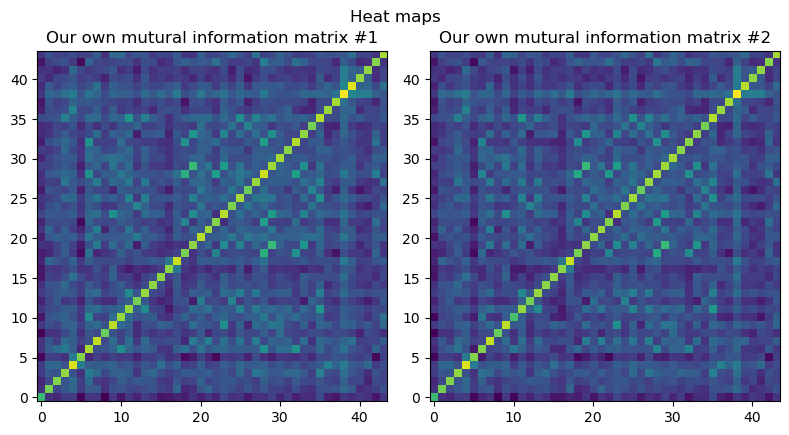

In [19]:
fig, ax = plt.subplots(1,2, figsize=(8,8))

ax[0].imshow(own_mut_matrix, interpolation='nearest',)
ax[1].imshow(own_mut_matrix_2, interpolation='nearest')

ax[0].title.set_text('Our own mutural information matrix #1')
ax[1].title.set_text('Our own mutural information matrix #2')

ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle("Heat maps", fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=1.4)
plt.show()

Plot contact map from our mutural information matrix

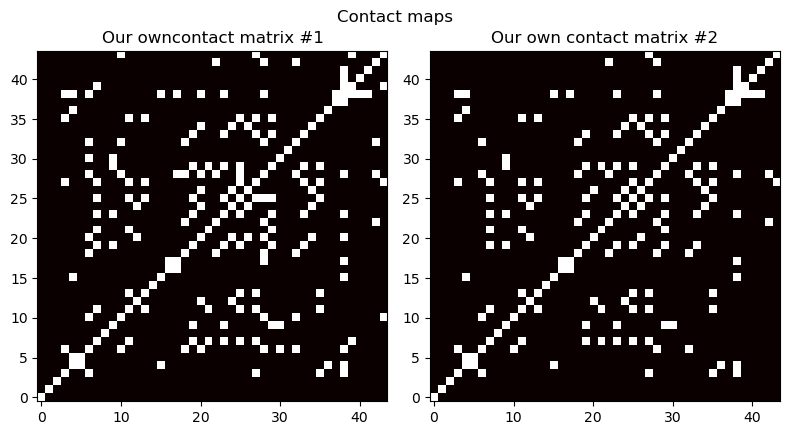

In [20]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
tau = 1.88

ax[0].imshow((own_mut_matrix > tau).astype(int), cmap='hot', interpolation='nearest')
ax[1].imshow((own_mut_matrix_2 > tau).astype(int), cmap='hot', interpolation='nearest')

ax[0].title.set_text('Our owncontact matrix #1')
ax[1].title.set_text('Our own contact matrix #2')

ax[0].invert_yaxis()
ax[1].invert_yaxis()

fig.suptitle("Contact maps", fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=1.4)
plt.show()

Let's compare mutural information matrix from our function and sklearn

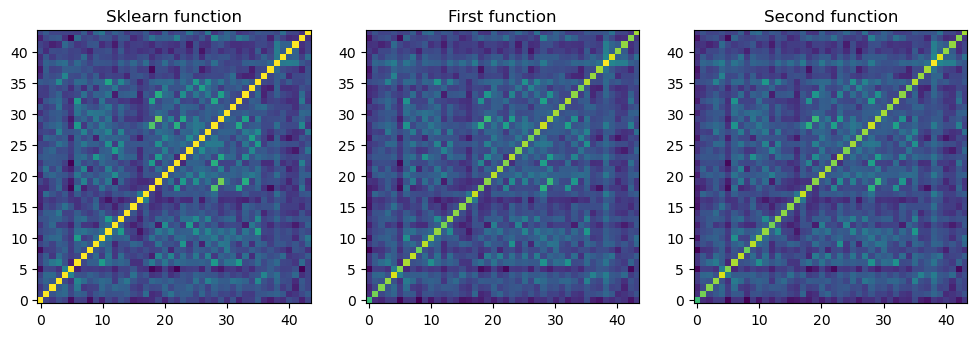

In [21]:
fig, ax = plt.subplots(1,3, figsize=(12,12))

ax[0].imshow(sk_mut_matrix, interpolation='nearest')
ax[1].imshow(own_mut_matrix, interpolation='nearest')
ax[2].imshow(own_mut_matrix, interpolation='nearest')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

ax[0].set_title('Sklearn function')
ax[1].set_title('First function')
ax[2].set_title('Second function')

plt.show()

We can see that results these matrix are the same. But we will use sklearn function because of normalization

# Getting contact map from tetR.pad

## Getting contact map from tetR.pad using mdtraj

In [22]:
import mdtraj as md
from contact_map import ContactMap, ContactFrequency, ContactDifference

In [23]:
traj = md.load('/Users/fomindmitry/Documents/Github/Computation-biology/prot-struct-pred-master/data/tetR.pdb')
frame_contacts = ContactFrequency(traj[0])
matrix_mdtraj = frame_contacts.residue_contacts.df.fillna(0)

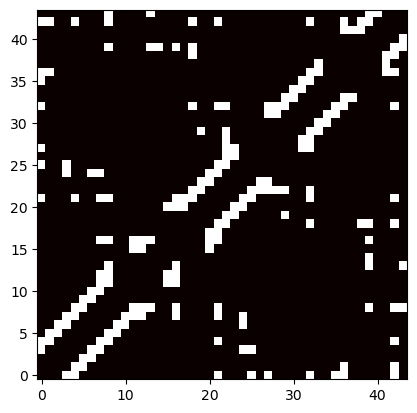

In [24]:
plt.imshow(matrix_mdtraj, cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()

# Getting contact map from tetR.pad using own functions

In [25]:
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO

# Parse and get basic information
parser=PDBParser()
protein = parser.get_structure('tetR', './prot-struct-pred-master/data/tetR.pdb')
#initialize IO 
io=PDBIO()

# write to output file
io.set_structure(protein)

# Extract the atom cordinates
coord = []
for chains in io.structure:
    for chain in chains:
        for residue in chain:                             
            for atom in residue:
                if atom.get_name() == 'CA': 
                    coord.append([atom.get_vector()[0],atom.get_vector()[1],atom.get_vector()[2]])
data = np.array(coord)

/opt/miniconda3/envs/env1/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 709
  warnings.warn(


Function for distance calculating

In [26]:
from scipy.spatial import distance

def euclidian(a,b):
    return distance.euclidean(a,b)

Calculate distance

In [27]:
matrix_euclidian = np.zeros((44,44))

for i in range(44):
    for j in range(44):
        matrix_euclidian[i][j] = euclidian(data[i],data[j])

Use threshold for our initial structure

In [28]:
matrix_euclidian_filt = (matrix_euclidian<9).astype(int)

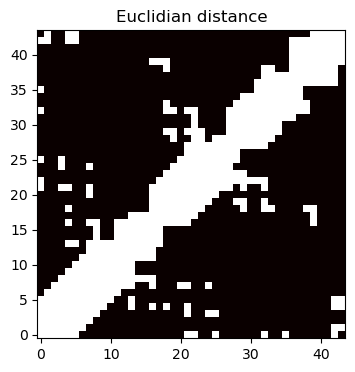

In [29]:
plt.figure(figsize = (4,4))
plt.imshow(matrix_euclidian_filt, cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()
plt.title("Euclidian distance")
plt.show()

We will use matrix that was computed with Euclidian distance. 

# Threshold choice

Let's find the range that we will use to find our threshold

In [30]:
sk_mut_matrix.min(), sk_mut_matrix.max()

(0.5560836463835503, 1.0000000000000004)

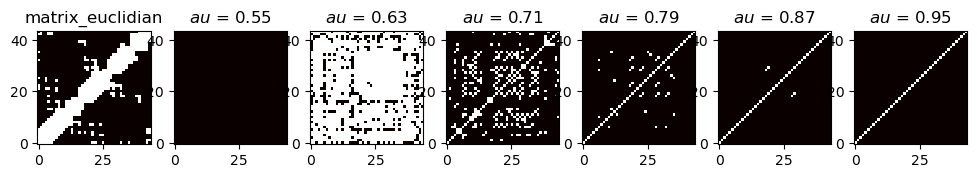

In [31]:
thrs = np.linspace(0.55, 0.95, 6)

fig, ax = plt.subplots(1, 7, figsize=(12,12))

ax[0].imshow(matrix_euclidian_filt, cmap='hot', interpolation='nearest')
ax[0].invert_yaxis()
ax[0].set_title("matrix_euclidian")

for i, thr in enumerate(thrs):
    ax[i+1].imshow((sk_mut_matrix > thr).astype(int), cmap='hot', interpolation='nearest')
    ax[i+1].invert_yaxis()
    ax[i+1].set_title(f'$\tau$ = {thr}')

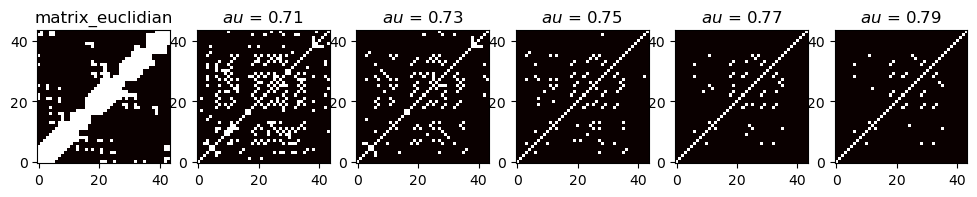

In [32]:
thrs = np.linspace(0.71, 0.79, 5)

fig, ax = plt.subplots(1, 6, figsize=(12,12))

ax[0].imshow(matrix_euclidian_filt, cmap='hot', interpolation='nearest')
ax[0].invert_yaxis()
ax[0].set_title("matrix_euclidian")

for i, thr in enumerate(thrs):
    ax[i+1].imshow((sk_mut_matrix > thr).astype(int), cmap='hot', interpolation='nearest')
    ax[i+1].invert_yaxis()
    ax[i+1].set_title(f'$\tau$ = {thr}')

We will use threshhold = 0.73

# Return final map

In [33]:
def get_res_matrix(matrix, thr):
    final_file = []
    for x in matrix:
        final_file += list(x.astype(int))
    final_file.insert(0, matrix.shape[0])
    with open(f"data/final_map_{thr}.cmap", 'w') as f:
        for x in final_file:
            f.write(str(x)+'\n')

In [34]:
thr = 0.73
get_res_matrix((sk_mut_matrix > thr).astype(int), thr)